# Create a Subscription Volume Prediction Model

There are well-defined gaps in our logbooks, and logbooks largely inform our subscription volume numbers. Given those gaps (and after removing events that aren't sourced by logbooks, how accurately can you predict subscription volume over a given time interval?

Complications:
* What time interval is best to use? Daily / Weekly / Monthly?
    * What is the largest common denominator that can be filled by the logbook gaps?
    * In order to neatly fit our vector, should we maybe intentionally drop data?
* Should a model be built for each gap? or trained on different gaps?
* Would predicting subscription subsets make the final prediction more accurate or less?
* There may be values incorrectly sourced as logbook subscriptions.

 
Notes:
* Any gaps fewer than 14 days were filtered out, and assumed to be vacation / holiday. [Other dates the shop could have been closed](https://docs.google.com/document/d/122oWT9ufc09PNWF1u-m4GFU-6dz49OTbz2plwHObKaU/edit)
* Use standard statistical model to verify results if possible.
* How might membership duration affect model efficacy? Is there a way to collapse other information when grouping by time interval?


In [1]:
import pandas as pd
import numpy as np
import json
from datetime import date, timedelta, datetime
import sklearn.metrics as metrics
from sklearn import svm
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from dateutil.parser import parse as date_parse
%matplotlib inline

# Prepare dataset

In [22]:
events_df = pd.read_csv(
    'https://dataspace.princeton.edu/bitstream/88435/dsp012n49t475g/2/SCoData_events_v1.1_2021-01.csv',
    parse_dates=['start_date']
)

In [23]:
events_df.columns

Index(['event_type', 'start_date', 'end_date', 'member_uris', 'member_names',
       'member_sort_names', 'subscription_price_paid', 'subscription_deposit',
       'subscription_duration', 'subscription_duration_days',
       'subscription_volumes', 'subscription_category',
       'subscription_purchase_date', 'reimbursement_refund', 'borrow_status',
       'borrow_duration_days', 'purchase_price', 'currency', 'item_uri',
       'item_title', 'item_volume', 'item_authors', 'item_year', 'item_notes',
       'source_type', 'source_citation', 'source_manifest', 'source_image'],
      dtype='object')

In [24]:
# Only select subscription events that are sourced by the logbooks
# Select only the columns that are immediately useful
df = events_df[
    events_df.event_type.isin(['Subscription']) &
    events_df.source_type.str.contains('Logbook')
][[
    'member_names',
    'event_type', 'start_date', 'end_date', 
   'subscription_duration', 'subscription_duration_days',
   'subscription_volumes', 'subscription_category',
   'source_type'
]].dropna(subset=['start_date'])

df['start_date'] = pd.to_datetime(df['start_date'])

# Determine Gaps in Logbooks

In [25]:
with open('logbook-dates.json') as f:
    logbook_dates = json.load(f)
    for d in logbook_dates:
        d['startDate'] = date_parse(d['startDate'])
        d['endDate'] = date_parse(d['endDate'])

logbook_gaps = []
for i, _ in enumerate(logbook_dates[1:-1]):
    start = logbook_dates[i]['endDate']
    end = logbook_dates[i+1]['startDate']
    interval = end - start
    if interval.days > 12:
        logbook_gaps.append({ 'start': start, 'end': end, 'interval': interval.days })

logbook_gaps

[{'start': datetime.datetime(1927, 12, 31, 0, 0),
  'end': datetime.datetime(1928, 3, 1, 0, 0),
  'interval': 61},
 {'start': datetime.datetime(1930, 1, 2, 0, 0),
  'end': datetime.datetime(1930, 6, 2, 0, 0),
  'interval': 151},
 {'start': datetime.datetime(1930, 7, 31, 0, 0),
  'end': datetime.datetime(1931, 1, 1, 0, 0),
  'interval': 154},
 {'start': datetime.datetime(1931, 2, 16, 0, 0),
  'end': datetime.datetime(1932, 9, 26, 0, 0),
  'interval': 588},
 {'start': datetime.datetime(1936, 12, 31, 0, 0),
  'end': datetime.datetime(1938, 2, 17, 0, 0),
  'interval': 413},
 {'start': datetime.datetime(1938, 5, 5, 0, 0),
  'end': datetime.datetime(1938, 10, 21, 0, 0),
  'interval': 169}]

In [26]:
def get_closest_date(d, index):
    return min([[abs(index_d - d), index_d] for index_d in index], key=lambda x: x[0])[1]

def add_logbook_vspans(ax, df_g):
    for gap in logbook_gaps:
        ax.axvspan(get_closest_date(gap['start'], df_g.index), 
                   get_closest_date(gap['end'], df_g.index),
            color="green", alpha=0.3)
    return ax

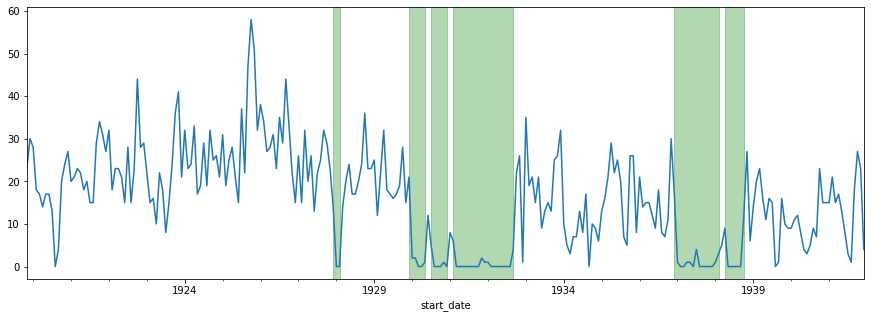

In [27]:
groups = df.groupby([pd.Grouper(key='start_date', freq='M')])['event_type'].count()
ax = groups.plot(figsize=(15, 5))
add_logbook_vspans(ax, groups)

In [28]:
# What events occur during the logbook gaps?
dfs = []
for gap in logbook_gaps:
    dfs.append(df[df['start_date'].between(gap['start'], gap['end'], inclusive=False)])
pd.concat(dfs).shape[0]

17

# Generate Features

In [29]:
# Filter logbook gaps dates out of the dataset
for gap in logbook_gaps:
    df = df[~df['start_date'].between(gap['start'], gap['end'], inclusive=False)]

In [32]:
df_t = df.groupby([pd.Grouper(key='start_date', freq='M')])['event_type'].count()
df_t = df_t[df_t != 0]
month_categorical = pd.get_dummies(df_t.index.month, prefix='month_')

def scale_year_data(series):
    MEAN = np.array(df_t.index.year.to_list()).mean()
    DIFF = df_t.max() - df_t.min()
    return (series - MEAN) / DIFF

# year_data = df_t.index.year
year_n = scale_year_data(df_t.index.year)

all_X = month_categorical.copy()
all_X['year_n'] = year_n
all_y = df_t.values

# Train and test model

In [33]:
def regression_results(y_true, y_pred):    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    all_X, all_y, test_size=0.33, random_state=42)

regr = svm.SVR()
model = regr.fit(X_train, y_train)
print('------- TEST -------')
regression_results(y_test, model.predict(X_test))
print('------- TRAIN -------')
regression_results(y_train, model.predict(X_train))

------- TEST -------
MAE:  7.1065
MSE:  84.6858
------- TRAIN -------
MAE:  6.9117
MSE:  82.0668
